In [287]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import os

In [3]:
### Here we point to the CESM2-LE datasets on campaign disk

monthly_output_path = "/glade/scratch/hannay/archive/b1850_high_freq/atm/hist"
run_name = "b1850_high_freq.cam.h0.0001-01.nc"

files = os.path.join(monthly_output_path,
                         run_name)
files

In [14]:
ds = xr.open_dataset(files)
ds

<xarray.Dataset>
Dimensions:           (lat: 96, lon: 144, lev: 32, ilev: 33, time: 1, nbnd: 2)
Coordinates:
  * lat               (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon               (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * lev               (lev) float64 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev              (ilev) float64 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time              (time) object 0001-02-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/401)
    gw                (lat) float64 ...
    hyam              (lev) float64 ...
    hybm              (lev) float64 ...
    P0                float64 ...
    hyai              (ilev) float64 ...
    hybi              (ilev) float64 ...
    ...                ...
    soa_c1            (time, lev, lat, lon) float32 ...
    soa_c1DDF         (time, lat, lon) float32 ...
    soa_c1SFWET       (time, lat, lon) float32 ...
    soa_c2            (time, lev, lat, lon) float32 ...
    soa_c2DDF         (time, lat, lon) float32 ...
    soa_c2SFWET       (time, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b1850_high_freq
    logname:           hannay
    host:              cheyenne2
    initial_file:      b.e20.B1850.f19_g17.release_cesm2_1_0.020.cam.i.0301-0...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_1.9x2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

---

### Example 1: Lat/Lon plot of TS

In [11]:
ds.TS

<xarray.DataArray 'TS' (time: 1, lat: 96, lon: 144)>
array([[[241.40042, 241.29715, ..., 241.43106, 241.42189],
        [242.92357, 242.57584, ..., 243.3707 , 243.18805],
        ...,
        [240.72127, 240.78133, ..., 240.59981, 240.65855],
        [240.48016, 240.49052, ..., 240.46257, 240.47038]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0001-02-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

In [51]:
# How you can grab the variable long name for plot title
ds.TS.long_name

'Surface temperature (radiative)'

In [312]:
# How you can grab the times in the dataset
ds.TS.time.values

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [313]:
# Grab data from first (and only in this case) time stamp
ds['TS'].sel({'time':ds.TS.time.values[0]}).squeeze()

<xarray.DataArray 'TS' (lat: 96, lon: 144)>
array([[241.40042, 241.29715, 241.27733, ..., 241.43352, 241.43106, 241.42189],
       [242.92357, 242.57584, 242.35805, ..., 243.54935, 243.3707 , 243.18805],
       [244.47028, 243.94136, 243.5683 , ..., 245.69241, 245.54506, 245.11273],
       ...,
       [241.264  , 241.4419 , 241.59529, ..., 240.8013 , 240.90965, 241.06944],
       [240.72127, 240.78133, 240.83948, ..., 240.54541, 240.59981, 240.65855],
       [240.48016, 240.49052, 240.50389, ..., 240.45454, 240.46257, 240.47038]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    time     object 0001-02-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

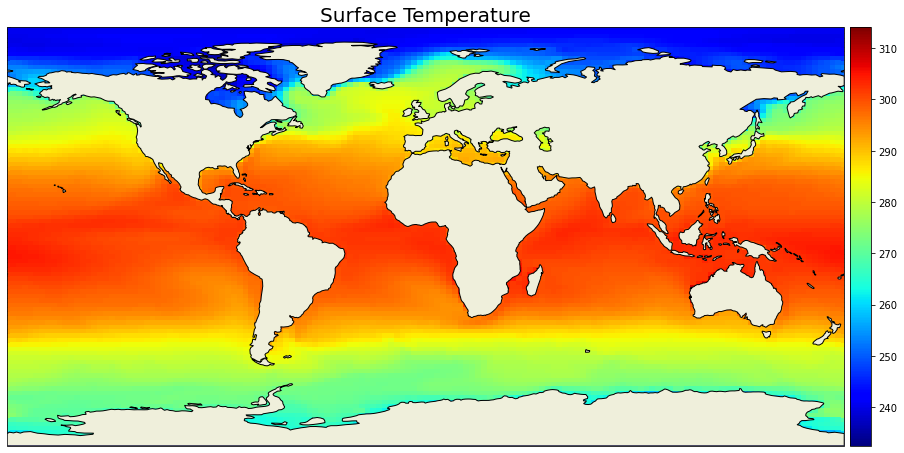

In [303]:
# define the colormap
cmap = plt.cm.get_cmap('jet')  

# set up the figure with a Plate Carree projection
fig = plt.figure(figsize=(15,10))


ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')

# sets the latitude / longitude boundaries of the plot
ax.set_extent([0.005, 360, 90, -90], crs=ccrs.PlateCarree())

#Plot the first timeslice of aice
this=ax.pcolormesh(ds['lon'],
                   ds['lat'],
                   ds['TS'].sel({'time':ds.TS.time.values[0]}).squeeze(),
                   cmap=cmap,#vmax=1,vmin=0,
                   transform=ccrs.PlateCarree())

plt.title("Surface Temperature",fontsize=20)

# Set up colorbar
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
posn = ax.get_position()

#Set position and size of colorbar position: [left, bottom, width, height]
cbar_ax.set_position([posn.x0 + posn.width + 0.005, posn.y0,
                          0.02, posn.height])

plt.colorbar(this,orientation='vertical',cax=cbar_ax)
plt.show()

---

### Example 2: Zonal plot of SWCF

In [284]:
ds_swcf = ds.SWCF

d = ds_swcf.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_swcf.mean(dim=davgovr)


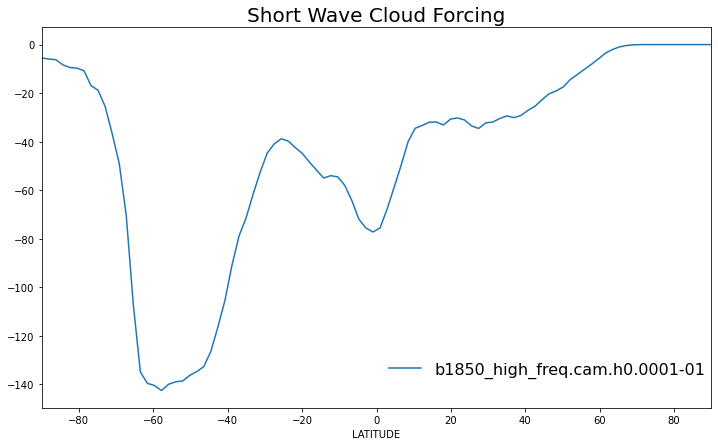

In [302]:
fig, ax = plt.subplots(1,figsize=(12,7))

# Set Main title for subplots:
plt.title("Short Wave Cloud Forcing",fontsize=20)

# Set legend for plot line
line = Line2D([0], [0], label=run_name[:-3],
                        color="#1f77b4")
fig.legend(handles=[line],bbox_to_anchor=(-0.15, 0.15, 1.05, .102),loc="right",
                   borderaxespad=0.0,fontsize=16,frameon=False)

ax.plot(DS['lat'], DS, c="#1f77b4")

ax.set_xlim([max([lat.min(), -90.]), min([lat.max(), 90.])])

ax.set_xlabel("LATITUDE")
plt.show()

---

### Example 3: Zonal Vertical Cross Section of T

In [ ]:
ds_t = ds.T.squeeze()

#### Natively via xarray

 - y-axis is <strong>increasing</strong> with height
 - y-axis is <strong>not</strong> in log pressure

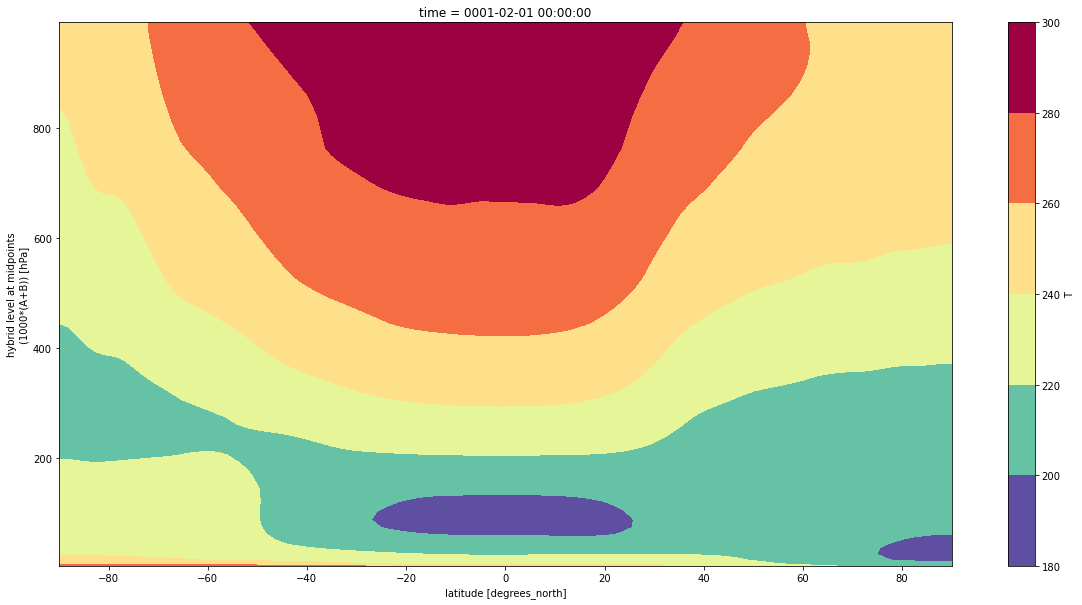

In [305]:
DS = zonal_mean_xr(ds_t)
#DS.transpose('lat', 'lev',...)
fig, ax = plt.subplots(1,figsize=(20,10))
DS.plot.contourf(ax=ax, y='lev',cmap="Spectral_r")
#DS.plot.contourf(ax=ax, y='lev', yscale='log')
plt.show()
fig.savefig("zonal_vert_T_xarray.png", bbox_inches='tight', dpi=300)

#### ADF style quick plot

 - y-axis is <strong>increasing</strong> with height
 - y-axis is <strong>not</strong> in log pressure

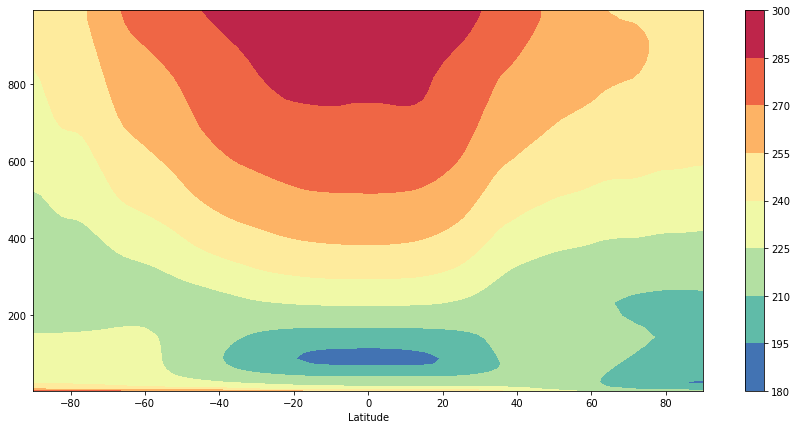

In [306]:
#Average over all dimensions except `lev` and `lat`.
d = ds_t.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_t.mean(dim=davgovr)

lev = DS['lev']
lat = DS['lat']
mlev, mlat = np.meshgrid(lev, lat)

# Generate zonal plot:
fig, ax = plt.subplots(1,figsize=(15,7))

# Create zonal plot with vertical levels 
img = ax.contourf(mlat, mlev, DS.transpose('lat', 'lev'), cmap='Spectral_r')

# Format axis and ticks
ax.set_xlabel("Latitude")
fig.colorbar(img, ax=ax, location='right')

fig.savefig("zonal_vert_T_ADF.png", bbox_inches='tight', dpi=300)

#### Same as above, but:

 - y-axis is <strong>decreasing</strong> with height
 - y-axis is <strong>not</strong> in log pressure

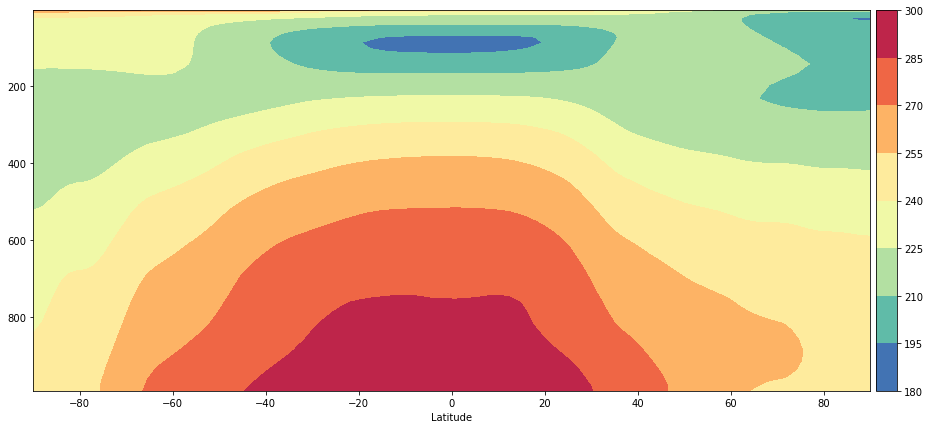

In [309]:
#Average over all dimensions except `lev` and `lat`.
d = ds_t.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_t.mean(dim=davgovr)

#print(DS.lev.min(),DS.lev.max())

lev = DS['lev']
lat = DS['lat']
mlev, mlat = np.meshgrid(lev, lat)

# Generate zonal plot:
fig, ax = plt.subplots(1,figsize=(15,7))

# Create zonal plot with vertical levels 
img = ax.contourf(mlat, mlev, DS.transpose('lat', 'lev'), cmap='Spectral_r')

# Format axis and ticks
plt.gca().invert_yaxis()
ax.tick_params(which='minor', length=4, color='r')

# Set up colorbar
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
posn = ax.get_position()

#Set position and size of colorbar position: [left, bottom, width, height]
cbar_ax.set_position([posn.x0 + posn.width + 0.005, posn.y0,
                          0.02, posn.height])

ax.set_xlabel("Latitude")
fig.colorbar(img, cax=cbar_ax,orientation='vertical')

fig.savefig("zonal_vert_T_ADF_invert.png", bbox_inches='tight', dpi=300)

#### Same as above, but:

 - y-axis is <strong>decreasing</strong> with height
 - y-axis <strong>is</strong> in log pressure

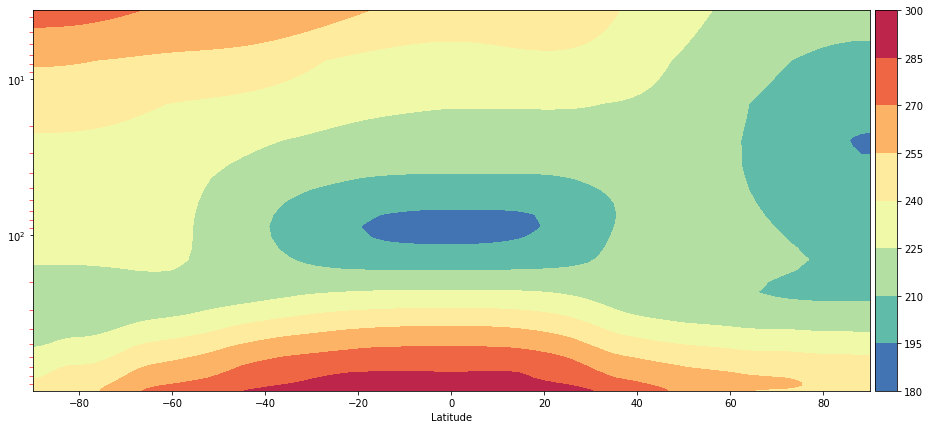

In [310]:
#Average over all dimensions except `lev` and `lat`.
d = ds_t.dims
davgovr = [dim for dim in d if dim not in ('lev','lat')]

DS = ds_t.mean(dim=davgovr)

#print(DS.lev.min(),DS.lev.max())

lev = DS['lev']
lat = DS['lat']
mlev, mlat = np.meshgrid(lev, lat)

# Generate zonal plot:
fig, ax = plt.subplots(1,figsize=(15,7))

# Create zonal plot with vertical levels 
img = ax.contourf(mlat, mlev, DS.transpose('lat', 'lev'), cmap='Spectral_r')

# Format axis and ticks
plt.yscale("log")
plt.gca().invert_yaxis()
ax.tick_params(which='minor', length=4, color='r')

# Set up colorbar
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
posn = ax.get_position()

#Set position and size of colorbar position: [left, bottom, width, height]
cbar_ax.set_position([posn.x0 + posn.width + 0.005, posn.y0,
                          0.02, posn.height])

ax.set_xlabel("Latitude")
fig.colorbar(img, cax=cbar_ax,orientation='vertical')

fig.savefig("zonal_vert_T_ADF_invert_log.png", bbox_inches='tight', dpi=300)